## Using pySpark for understanding and analysing basic things from 'vericred' projects.  

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Analysis").getOrCreate()
print(spark.sparkContext.appName)
#http://localhost:4040/jobs/

22/03/10 10:39:36 WARN Utils: Your hostname, Anishs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.90.85 instead (on interface en0)
22/03/10 10:39:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/10 10:39:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Analysis


In [21]:
import pandas as pd
import klib #Customized data preprocessing functions for frequent tasks
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
file1 = "/Users/anishchapagain/Downloads/vericred_az_mercy_care_20211207.json"

### <hr /> Reading JSON file. 

In [4]:
df = spark.read.json(path=file1)
type(df)

pyspark.sql.dataframe.DataFrame

#### Shows total records plus distinct records count

In [5]:
totalRow = df.count()
print("Count ",totalRow)
print("Distinct Count ",df.distinct().count())

Count  113429


Distinct Count  113429


### <hr /> Schema

### Describes the structure of your data. Using <b>StructType</b> class which is a collection of <b>StructField</b> that define the column name(String), column type (DataType), nullable column (Boolean) and metadata (MetaData)

In [6]:
df.schema

StructType(List(StructField(addresses,ArrayType(StructType(List(StructField(address_string,StringType,true),StructField(city,StringType,true),StructField(languages,ArrayType(StructType(List(StructField(name,StringType,true),StructField(type,StringType,true))),true),true),StructField(office_name,StringType,true),StructField(phones,ArrayType(StructType(List(StructField(type,StringType,true),StructField(value,StringType,true))),true),true),StructField(state,StringType,true),StructField(street_line_1,StringType,true),StructField(street_line_2,StringType,true),StructField(zip,StringType,true))),true),true),StructField(group_affiliations,ArrayType(StructType(List(StructField(name,StringType,true))),true),true),StructField(hospital_affiliations,ArrayType(StringType,true),true),StructField(networks,ArrayType(StructType(List(StructField(name,StringType,true),StructField(tier,StringType,true))),true),true),StructField(provider,StructType(List(StructField(accepting_new_patients,BooleanType,true),

### printSchema() : displays schema in tree format 

In [7]:
df.printSchema()

root
 |-- addresses: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address_string: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- languages: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |-- office_name: string (nullable = true)
 |    |    |-- phones: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |    |-- street_line_1: string (nullable = true)
 |    |    |-- street_line_2: string (nullable = true)
 |    |    |-- zip: string (nullable = true)
 |-- group_affiliations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- 

### Collecting major StructTypes in the DataFrame.

In [8]:
df.schema.names #column names

['addresses',
 'group_affiliations',
 'hospital_affiliations',
 'networks',
 'provider',
 'specialties']

In [9]:
df.columns #columns

['addresses',
 'group_affiliations',
 'hospital_affiliations',
 'networks',
 'provider',
 'specialties']

### <hr /> Check empty Columns/Schema

In [10]:
emptyCols={}
for col in df.schema:
    print('Node: ',col.name, 'Type: ',col.dataType.typeName())
    if(col.dataType.typeName()=='array'):
        if df.select(explode(col.name)).count()==0:
            emptyCols[col.name]='empty'

Node:  addresses Type:  array


Node:  group_affiliations Type:  array
Node:  hospital_affiliations Type:  array
Node:  networks Type:  array
Node:  provider Type:  struct
Node:  specialties Type:  array


In [11]:
emptyCols

{'hospital_affiliations': 'empty'}

In [12]:
df.select('hospital_affiliations').printSchema() #verifying

root
 |-- hospital_affiliations: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [13]:
df.select('provider').schema.fields

[StructField(provider,StructType(List(StructField(accepting_new_patients,BooleanType,true),StructField(facility_name,StringType,true),StructField(facility_type,StringType,true),StructField(first_name,StringType,true),StructField(gender,StringType,true),StructField(last_name,StringType,true),StructField(license_number,StringType,true),StructField(middle_name,StringType,true),StructField(npi,StringType,true),StructField(pcp,BooleanType,true),StructField(pcp_id,StringType,true),StructField(provider_type,StringType,true),StructField(rating,StructType(List(StructField(scale,StringType,true),StructField(score,StringType,true))),true),StructField(site_uid,StringType,true),StructField(suffix,StringType,true),StructField(title,StringType,true),StructField(unparsed_name,StringType,true))),true)]

### <hr /> Printing 'addresses' and 'provider' nodes schema from main schema

In [14]:
df.select('addresses').printSchema()  # select(): to select single or multiple columns

root
 |-- addresses: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address_string: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- languages: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |-- office_name: string (nullable = true)
 |    |    |-- phones: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |    |-- street_line_1: string (nullable = true)
 |    |    |-- street_line_2: string (nullable = true)
 |    |    |-- zip: string (nullable = true)



In [15]:
df.select('provider.npi').printSchema()

root
 |-- npi: string (nullable = true)



### Records from DataFrame (show, select)

In [16]:
df.show() 

+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|           addresses|  group_affiliations|hospital_affiliations|            networks|            provider|         specialties|
+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|[{3033 S Arizona ...|[{Buena Vista Rec...|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{675 S Avenue B,...|                  []|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{811 N Tegner St...|                  []|                   []|[{Mercy Care Comp...|{null, null, null...| [{Family Practice}]|
|[{6879 N Oracle R...|[{Wellbeing Insti...|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{4475 S I19 Fron...|[{Continental Fam...|                   []|[{Mercy Care Comp...|{null, null

In [17]:
df.show(10)

+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|           addresses|  group_affiliations|hospital_affiliations|            networks|            provider|         specialties|
+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|[{3033 S Arizona ...|[{Buena Vista Rec...|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{675 S Avenue B,...|                  []|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{811 N Tegner St...|                  []|                   []|[{Mercy Care Comp...|{null, null, null...| [{Family Practice}]|
|[{6879 N Oracle R...|[{Wellbeing Insti...|                   []|[{Mercy Care Comp...|{null, null, null...|[{Addiction Medic...|
|[{4475 S I19 Fron...|[{Continental Fam...|                   []|[{Mercy Care Comp...|{null, null

In [18]:
df.select('networks','specialties').show(5,truncate=False) #show(truncate=False)

+------------------------------+---------------------------------------------------------+
|networks                      |specialties                                              |
+------------------------------+---------------------------------------------------------+
|[{Mercy Care Complete Care, }]|[{Addiction Medicine}, {Internal Medicine}]              |
|[{Mercy Care Complete Care, }]|[{Addiction Medicine}, {Family Practice}]                |
|[{Mercy Care Complete Care, }]|[{Family Practice}]                                      |
|[{Mercy Care Complete Care, }]|[{Addiction Medicine}, {Surgery-Hand}, {Surgery-Plastic}]|
|[{Mercy Care Complete Care, }]|[{Family Practice}]                                      |
+------------------------------+---------------------------------------------------------+
only showing top 5 rows



### <hr />Count: 'provider->provider_type', toPandas()

In [22]:
providerType = df.groupby("provider.provider_type").count().orderBy(col('count').desc())  #Counts various 'provider_type' values from 'provider'

In [23]:
providerType.show() # show(): displays records of DataFrame

+-------------+-----+
|provider_type|count|
+-------------+-----+
|   individual|76525|
|     facility|36904|
+-------------+-----+



In [24]:
providerType.select('count').describe().show()

+-------+----------------+
|summary|           count|
+-------+----------------+
|  count|               2|
|   mean|         56714.5|
| stddev|28016.2777773922|
|    min|           36904|
|    max|           76525|
+-------+----------------+



In [25]:
providerType.toPandas() #back to a pandas DataFrame to leverage pandas API 

,provider_type,count
0,individual,76525
1,facility,36904


<AxesSubplot:xlabel='provider_type'>

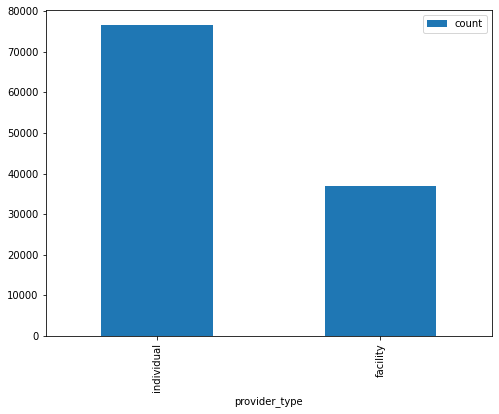

In [26]:
providerType.toPandas().set_index('provider_type').plot(kind='bar',figsize=(8,6))

In [27]:
providerType.show(vertical=True)

-RECORD 0-------------------
 provider_type | individual 
 count         | 76525      
-RECORD 1-------------------
 provider_type | facility   
 count         | 36904      



### <b>filter, where</b>: applying conditions

In [28]:
individualDF=providerType.filter(providerType.provider_type=="individual").select('count') #new DataFrame with column 'count'

In [29]:
individualDF.show()

+-----+
|count|
+-----+
|76525|
+-----+



In [30]:
individualDF.schema # schema

StructType(List(StructField(count,LongType,false)))

In [31]:
df.filter(df.provider.last_name == "Williams").count() 

231

In [32]:
df.filter(df.provider.last_name.like("%Williams%")).count() # like

265

In [33]:
df.filter(df.provider.last_name.rlike("Williams$")).count() #rlike : regex

236

In [37]:
df.filter(df.provider.unparsed_name.rlike("^B.*Williams$")).select(['provider.npi','provider.unparsed_name','specialties']).show(truncate=False)

+----------+-----------------+----------------------------------------------------------------------+
|npi       |unparsed_name    |specialties                                                           |
+----------+-----------------+----------------------------------------------------------------------+
|1487033452|Benjamin Williams|[{Family Practice}]                                                   |
|1487033452|Benjamin Williams|[{Family Practice}]                                                   |
|1487033452|Benjamin Williams|[{Family Practice}]                                                   |
|1487033452|Benjamin Williams|[{Family Medicine}, {Family Practice}]                                |
|1487033452|Benjamin Williams|[{Family Medicine}, {Family Practice}]                                |
|1073578159|Brian Williams   |[{Family Practice}]                                                   |
|1073578159|Brian Williams   |[{Family Practice}]                                 

In [38]:
df.where(df.provider.npi == 1487033452).select(['provider.*']).show(truncate=False)

+----------------------+-------------+-------------+----------+------+---------+--------------+-----------+----------+----+------+-------------+------------+--------------+------+-----+-----------------+
|accepting_new_patients|facility_name|facility_type|first_name|gender|last_name|license_number|middle_name|npi       |pcp |pcp_id|provider_type|rating      |site_uid      |suffix|title|unparsed_name    |
+----------------------+-------------+-------------+----------+------+---------+--------------+-----------+----------+----+------+-------------+------------+--------------+------+-----+-----------------+
|null                  |null         |null         |Benjamin  |M     |Williams |007706        |           |1487033452|null|null  |individual   |{null, null}|cbf42943bd243d|DO    |null |Benjamin Williams|
|null                  |null         |null         |Benjamin  |M     |Williams |007706        |           |1487033452|null|null  |individual   |{null, null}|1197de039bceef|DO    |null 

### <hr />Analysing 'Networks'

In [39]:
df.select('networks').printSchema()  # Schema - array field

root
 |-- networks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- tier: string (nullable = true)



In [40]:
df.select('networks').show(5,truncate=False)  #preview

+------------------------------+
|networks                      |
+------------------------------+
|[{Mercy Care Complete Care, }]|
|[{Mercy Care Complete Care, }]|
|[{Mercy Care Complete Care, }]|
|[{Mercy Care Complete Care, }]|
|[{Mercy Care Complete Care, }]|
+------------------------------+
only showing top 5 rows



In [41]:
networkDF = df.select(explode(df.networks)) # explode(): nested array into rows

In [42]:
networkDF.printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- tier: string (nullable = true)



In [43]:
networks = networkDF.select('col.name','col.tier')
networks.printSchema()

root
 |-- name: string (nullable = true)
 |-- tier: string (nullable = true)



In [44]:
networkCount = networks.groupBy("name").count().orderBy(col('count').desc())
networkCount.show(10,truncate=False)

+-----------------------------------+-----+
|name                               |count|
+-----------------------------------+-----+
|Mercy Care Advantage               |20457|
|Mercy Care Long Term Care          |19895|
|Mercy Care Complete Care           |19798|
|Mercy Care Developmentally Disabled|19608|
|Mercy Care DCS CHP                 |14808|
|Mercy Care RBHA                    |12002|
|Behavioral Health Only             |6861 |
+-----------------------------------+-----+



### Temp View for SQL

In [45]:
networkCount.createOrReplaceTempView("NET")   #spark.catalog.dropTempView("NET")

In [46]:
spark.sql("select name from NET where count > 15000 order by count desc").show(truncate=False)

+-----------------------------------+
|name                               |
+-----------------------------------+
|Mercy Care Advantage               |
|Mercy Care Long Term Care          |
|Mercy Care Complete Care           |
|Mercy Care Developmentally Disabled|
+-----------------------------------+



#### using Pandas: network values

In [47]:
networkCount.toPandas().describe()

,count
count,7.000000
mean,16204.142857
std,5213.968592
min,6861.000000
25%,13405.000000
50%,19608.000000
75%,19846.500000
max,20457.000000


<AxesSubplot:xlabel='name'>

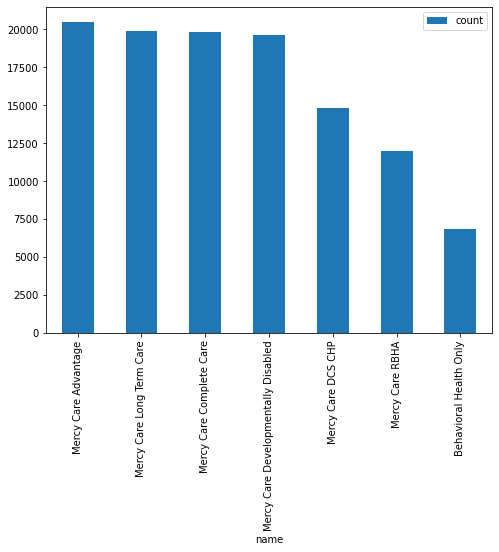

In [48]:
networkCount.toPandas().set_index('name').plot(kind='bar',figsize=(8,6))

### <hr /> Exploring ... Specialties

In [49]:
specs = df.select(explode(df.specialties)).select('col.name').groupBy(col("name")).count().orderBy(col('count').desc())
print('Total Specialties: {}',specs.count(),', Distinct: {}',specs.distinct().count())

Total Specialties: {} 337 , Distinct: {} 337


In [50]:
specs.tail(20)

[Row(name='Dentist - Pediatric Dentist', count=4),
 Row(name='Physician Assistant - Psychiatry', count=4),
 Row(name='Surgical Services (Outpatient or ASC)', count=3),
 Row(name='Licensed Professional Counselor (LPC)', count=3),
 Row(name='Dental Hygienist', count=3),
 Row(name='Roentgenology (Diagnostic)', count=3),
 Row(name='Homeopathic', count=2),
 Row(name='Resid Trtm Ctr-Non-Secure (17Plusbeds)(Imd)', count=2),
 Row(name='Community or Rural Health Center', count=1),
 Row(name='THERAPIST-PHYSICAL', count=1),
 Row(name='Mhs Social Worker', count=1),
 Row(name='RN Midwife', count=1),
 Row(name='Dentist - Periodontist', count=1),
 Row(name='Dentist - Prosthodontist', count=1),
 Row(name='RN Adult Nurse Practitioner', count=1),
 Row(name='Dentist - Orthodontist', count=1),
 Row(name='RN Pediatric Nurse Practitioner', count=1),
 Row(name='Assisted Living Home (Formerly ACH)', count=1),
 Row(name='Pediatric - Neonatal/Perinatal Medicine', count=1),
 Row(name='BH Outpatient Clinic', coun

### Group Affiliations

In [51]:
groups = df.select(explode(df.group_affiliations)).select('col.name').groupBy(col("name")).count().orderBy(col('count').desc())
print('Total: {}',groups.count(),', Distinct: {}',groups.distinct().count())

Total: {} 4730 , Distinct: {} 4730


### <hr />TESTING

In [52]:
df.printSchema()

root
 |-- addresses: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address_string: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- languages: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |-- office_name: string (nullable = true)
 |    |    |-- phones: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |    |-- street_line_1: string (nullable = true)
 |    |    |-- street_line_2: string (nullable = true)
 |    |    |-- zip: string (nullable = true)
 |-- group_affiliations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- 

In [53]:
df.select('provider.*').schema.names

['accepting_new_patients',
 'facility_name',
 'facility_type',
 'first_name',
 'gender',
 'last_name',
 'license_number',
 'middle_name',
 'npi',
 'pcp',
 'pcp_id',
 'provider_type',
 'rating',
 'site_uid',
 'suffix',
 'title',
 'unparsed_name']

In [62]:
df.select([count(when(col('provider.npi').isNull(),True)).alias('Null NPI')]).show()

+--------+
|Null NPI|
+--------+
|   18614|
+--------+



In [63]:
type(df.select('provider.*'))

pyspark.sql.dataframe.DataFrame

In [64]:
providerDF = df.select(['provider.first_name','provider.last_name','provider.middle_name','provider.gender','provider.npi']) #provider.* : all

In [65]:
providerDF.show(2)

+----------+---------+-----------+------+----------+
|first_name|last_name|middle_name|gender|       npi|
+----------+---------+-----------+------+----------+
|     Reyes|   Topete|           |     M|1487611158|
|    Robert|    Allen|           |     M|1821049800|
+----------+---------+-----------+------+----------+
only showing top 2 rows



In [66]:
for c in providerDF:
    print(c)
    print(providerDF.select(c).show(3))
    break

Column<'first_name'>
+----------+
|first_name|
+----------+
|     Reyes|
|    Robert|
|    Robert|
+----------+
only showing top 3 rows

None


In [67]:
df.select([count(when(col('provider.middle_name').isNull(),True)).alias('Empty MiddleName')]).show()

+----------------+
|Empty MiddleName|
+----------------+
|           36904|
+----------------+



In [68]:
providerDF.select([count(clm) for clm in providerDF]).show()

+-----------------+----------------+------------------+-------------+----------+
|count(first_name)|count(last_name)|count(middle_name)|count(gender)|count(npi)|
+-----------------+----------------+------------------+-------------+----------+
|            76525|           76525|             76525|        76511|     94815|
+-----------------+----------------+------------------+-------------+----------+



In [69]:
providerDF.select([count(when(col('first_name').isNull(),True)).alias('Empty FirstName'),
                   count(when(col('last_name').isNull(),True)).alias('Empty LastName'),
                   count(when(col('middle_name').isNull(),True)).alias('Empty MiddleName'),
                   count(when(col('gender').isNull(),True)).alias('Empty Gender')
                  ]).show()

+---------------+--------------+----------------+------------+
|Empty FirstName|Empty LastName|Empty MiddleName|Empty Gender|
+---------------+--------------+----------------+------------+
|          36904|         36904|           36904|       36918|
+---------------+--------------+----------------+------------+



In [70]:
providerType.show()

+-------------+-----+
|provider_type|count|
+-------------+-----+
|   individual|76525|
|     facility|36904|
+-------------+-----+



### <hr />Cleaning resources

In [ ]:
spark.catalog.dropTempView("NET")

In [12]:
spark.stop()